In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from mpl_toolkits import mplot3d
from matplotlib import cm
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc
from sklearn.metrics import pairwise_distances
from scipy.stats import wilcoxon, mannwhitneyu
from sklearn.preprocessing import StandardScaler
import copy

In [3]:
data = pd.read_csv("../data/input_data.csv")
data

,Unnamed: 0,FEC_HORA_INI,NOM_ELEMENTO,COD_ELEMENTO,NOM_INSTALACION,BIN_YAW,Sum_Of_Avg_W_In_Bin,Yaw_Bin_Rank
0,0,2020-10-01,002,11267.0,BLUE CREEK,"(26, Infinito]",2819.48,1.0
1,1,2020-10-01,003,11268.0,BLUE CREEK,"(26, Infinito]",2991.07,1.0
2,2,2020-10-01,004,11269.0,BLUE CREEK,"(26, Infinito]",2932.53,1.0
3,3,2020-10-01,005,11270.0,BLUE CREEK,"(26, Infinito]",2937.90,1.0
4,4,2020-10-01,007,11271.0,BLUE CREEK,"(26, Infinito]",2915.70,1.0
...,...,...,...,...,...,...,...,...
57259,57259,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(14, 18]",2718.96,11.0
57260,57260,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(-Infinito, -26]",2693.18,12.0
57261,57261,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(26, Infinito]",2644.22,13.0
57262,57262,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(18, 22]",2525.33,14.0


In [4]:
data = data.drop(["Unnamed: 0"], axis=1)
data

,FEC_HORA_INI,NOM_ELEMENTO,COD_ELEMENTO,NOM_INSTALACION,BIN_YAW,Sum_Of_Avg_W_In_Bin,Yaw_Bin_Rank
0,2020-10-01,002,11267.0,BLUE CREEK,"(26, Infinito]",2819.48,1.0
1,2020-10-01,003,11268.0,BLUE CREEK,"(26, Infinito]",2991.07,1.0
2,2020-10-01,004,11269.0,BLUE CREEK,"(26, Infinito]",2932.53,1.0
3,2020-10-01,005,11270.0,BLUE CREEK,"(26, Infinito]",2937.90,1.0
4,2020-10-01,007,11271.0,BLUE CREEK,"(26, Infinito]",2915.70,1.0
...,...,...,...,...,...,...,...
57259,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(14, 18]",2718.96,11.0
57260,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(-Infinito, -26]",2693.18,12.0
57261,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(26, Infinito]",2644.22,13.0
57262,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(18, 22]",2525.33,14.0


In [11]:
columns = ['Date',"Name_Element","code_element","Location","BIN_YAW","Sum_Avg_W_In_Bin",
           "Yaw_Bin_Rank"]

In [12]:
df = pd.read_csv("../data/input_data.csv", skiprows=1, names=columns)
df.head()

,Date,Name_Element,code_element,Location,BIN_YAW,Sum_Avg_W_In_Bin,Yaw_Bin_Rank
0,2020-10-01,002,11267.0,BLUE CREEK,"(26, Infinito]",2819.48,1.0
1,2020-10-01,003,11268.0,BLUE CREEK,"(26, Infinito]",2991.07,1.0
2,2020-10-01,004,11269.0,BLUE CREEK,"(26, Infinito]",2932.53,1.0
3,2020-10-01,005,11270.0,BLUE CREEK,"(26, Infinito]",2937.90,1.0
4,2020-10-01,007,11271.0,BLUE CREEK,"(26, Infinito]",2915.70,1.0


In [15]:
df.Name_Element.unique()

array(['002', '003', '004', ..., 'Z3', 'Z4', 'Z5'], dtype=object)

# Defining a scoring function which provides alert severity

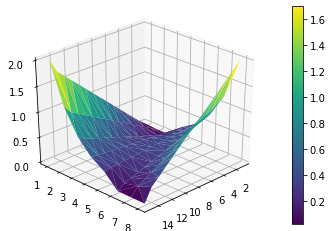

In [4]:
num_ranks = 15
values = [-50, -30, -10, 1, 1.5, 2, 2.5, 3]
dampening_factor = 0.1
severity_score = [list() for i in range(num_ranks)]


# first generate all severity scores for only positive bins
# generate alert severity for rank=1
for i in values:
    severity_score[0].append(dampening_factor*np.exp(i))

# Generate alert severity for rank=1
severity_score[-1] = sorted(severity_score[0], reverse=True)

# Now generate intermediate severity scores for remaining ranks
delta = [abs((severity_score[0][j] - severity_score[-1][j]) / num_ranks) for j in range(len(values))]
for i in range(1, num_ranks-1):
    # First add till half of bins
    mid = math.ceil(len(values)/2)
    for j in range(mid):
        severity_score[i].append(severity_score[i-1][j]+delta[j])
    for j in range(mid, len(values)):
        severity_score[i].append(severity_score[i-1][j]-delta[j])

        
# Lets plot the severitiy scores for different ranks
# lets plot the diagrame here with matplotlib 

fig = plt.figure()
ax = plt.axes(projection='3d')

scoring_function_3d = list()
for i in range(num_ranks):
    for j in range(len(values)):
        scoring_function_3d.append([i+1, j+1, severity_score[i][j]])
scoring_function_3d = np.array(scoring_function_3d)

surf = ax.plot_trisurf(scoring_function_3d[:,0], scoring_function_3d[:,1], scoring_function_3d[:,2],
       cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf)
ax.view_init(30, 45)
plt.show()

# plt.savefig("../images/severity_score.png", dpi=400)


# Generate a new column containing severity score for each bin+rank

In [5]:
tmp = list()
X1, X2 = data["BIN_YAW"].values, data["Yaw_Bin_Rank"].values
for i in range(len(X1)):
    if "26" in X1[i] and "Infinito" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-1])
    elif "26" in X1[i] and "22" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-2])
    elif "22" in X1[i] and "18" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-3])
    elif "18" in X1[i] and "14" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-4])
    elif "14" in X1[i] and "10" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-5])
    elif "10" in X1[i] and "6" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-6])
    elif "6" in X1[i] and "2" in X1[i]:
        tmp.append(severity_score[int(X2[i])-1][-7])
    else:
        tmp.append(severity_score[int(X2[i])-1][0])
data["severity_scores"] = tmp
display(data)

,FEC_HORA_INI,NOM_ELEMENTO,COD_ELEMENTO,NOM_INSTALACION,BIN_YAW,Sum_Of_Avg_W_In_Bin,Yaw_Bin_Rank,severity_scores
0,2020-10-01,002,11267.0,BLUE CREEK,"(26, Infinito]",2819.48,1.0,2.008554e+00
1,2020-10-01,003,11268.0,BLUE CREEK,"(26, Infinito]",2991.07,1.0,2.008554e+00
2,2020-10-01,004,11269.0,BLUE CREEK,"(26, Infinito]",2932.53,1.0,2.008554e+00
3,2020-10-01,005,11270.0,BLUE CREEK,"(26, Infinito]",2937.90,1.0,2.008554e+00
4,2020-10-01,007,11271.0,BLUE CREEK,"(26, Infinito]",2915.70,1.0,2.008554e+00
...,...,...,...,...,...,...,...,...
57259,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(14, 18]",2718.96,11.0,3.306084e-01
57260,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(-Infinito, -26]",2693.18,12.0,5.356143e-01
57261,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(26, Infinito]",2644.22,13.0,4.017107e-01
57262,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(18, 22]",2525.33,14.0,9.852468e-02


# Plot Alert Severity for each wind farm

% of farms having erroneous data:  20.930232558139537


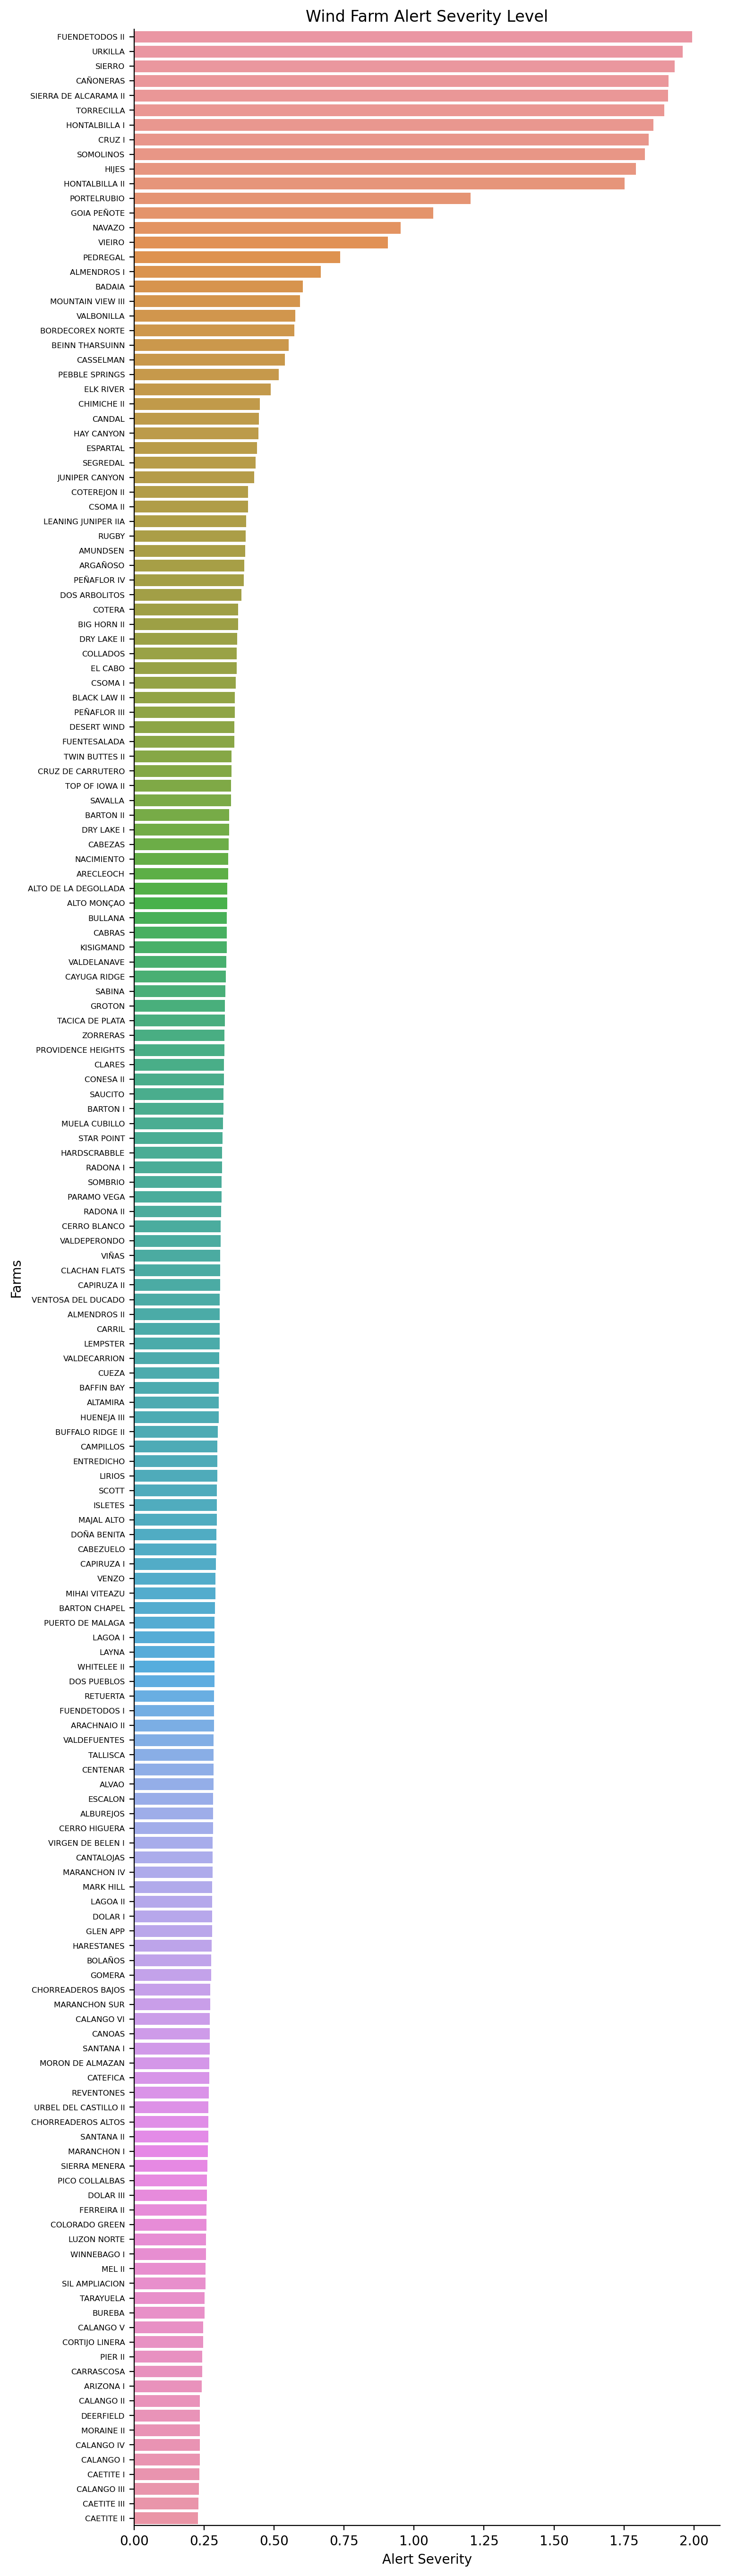

<Figure size 432x288 with 0 Axes>

In [17]:
# All of the wind farms
wind_farms = data["NOM_INSTALACION"].unique()

# The count of each yaw_bin for each farm
wind_farm_yaw_severity = data.groupby(["NOM_INSTALACION"])["severity_scores"].sum()
wind_farm_yaw_bin_num = data.groupby(["NOM_INSTALACION"])["BIN_YAW"].unique()
total_turbines = data.groupby(["NOM_INSTALACION"])["COD_ELEMENTO"].nunique()
count = data.groupby(["NOM_INSTALACION"])["severity_scores"].count()


# farm_alert_severity is a list of tuples containing farm and corresponding severity score
farm_alert_severity, erroneous_farms = list(), list()
for farm in wind_farms:
    if len(wind_farm_yaw_bin_num[farm]) > 1:
        farm_alert_severity.append([farm, wind_farm_yaw_severity[farm]/count[farm]])
    else:
        erroneous_farms.append(farm)
print("% of farms having erroneous data: ", (len(erroneous_farms)/len(wind_farms))*100)

# Sort the farms according to their corresponding severity in descending order
farm_alert_severity.sort(key=lambda x: x[1], reverse=True)

# Now plot the results
plt.figure(figsize=(8, 35), dpi=200, facecolor='w', edgecolor='k')
plot = sns.barplot([j for i, j in farm_alert_severity], [i for i, j in farm_alert_severity])
plot.set_yticklabels(plt.yticks()[1], size = 6)
sns.despine()
plt.xlabel("Alert Severity")
plt.ylabel("Farms")
plt.title("Wind Farm Alert Severity Level")
plt.show()

plt.savefig("../images/Normalized.png", dpi=400)

# Save in csv
fp = open("../data/farm_alert_severity.csv", "w")
fp.write("Wind Farm,Severity Score\n")
for i in range(len(farm_alert_severity)):
    fp.write(farm_alert_severity[i][0]+","+str(farm_alert_severity[i][1])+"\n")
fp.close()
    
    

# Plot alert severity for each Wind Turbine model

In [ ]:
# all turbine models

turbine_models = data["Model"].unique()

# the count for each Yaw bin for each model
turbine_model_yaw_severity = data.groupby(["Model"])["severity_score"].sum()
turbine_model_yaw_bin_num = data.groupby(["Model"])["BIN_YAW"].unique()
count = data.groupby(["Model"])["severity_scores"].count()

# turbine_model_alert_severity is a list of tuples containing turbine model and corresponding severity score
turbine_model_alert_severity = list()
for model in turbine_models:
    turbine_model_alert_severity.append(key=lambda x: x[1], reverse=True)
    
# sort the turbine models according to their correspoding severity in descending order
turbine_model_alert_severity.sort(key=lambda x:x[1], reverse=True)

# now plot the results
plt.figure(figsize=(8,10), dpi=200, facecolor="w", edgecolor="k")
plot = sns.barplot([j for i, j in turbine_model_alert_severity], [i for i, j in turbine_model_alert_severity])
plot.set_yticklabels(plt.yticks()[1], size = 6)
sns.despine()
plt.xlabel("Alert Severity")
plt.ylabel("Turbine Models")
plt.title("Turbine Model Alert Severity Level")
plt.show()

# save in csv
fp = open("../data/turbine_model_alert_severity.csv", "w")
fp.write("Turbine, Severity Score\n")
for i in range(len(turbine_model_alert_severity)):
    fp.write(turbine_model_alert_severity[i][0]+","+str(turbine_model_alert_severity[i][1])+"\n")
fp.close()    

In [10]:
data.head()

,FEC_HORA_INI,NOM_ELEMENTO,COD_ELEMENTO,NOM_INSTALACION,BIN_YAW,Sum_Of_Avg_W_In_Bin,Yaw_Bin_Rank,severity_scores
0,2020-10-01,002,11267.0,BLUE CREEK,"(26, Infinito]",2819.48,1.0,2.008554
1,2020-10-01,003,11268.0,BLUE CREEK,"(26, Infinito]",2991.07,1.0,2.008554
2,2020-10-01,004,11269.0,BLUE CREEK,"(26, Infinito]",2932.53,1.0,2.008554
3,2020-10-01,005,11270.0,BLUE CREEK,"(26, Infinito]",2937.90,1.0,2.008554
4,2020-10-01,007,11271.0,BLUE CREEK,"(26, Infinito]",2915.70,1.0,2.008554


# Plot alert severity of each farm for every turbine model

In [ ]:
for i in data.groupby(["Model"]):
    new_data = i[1]
    turbine_model = i[0].replace("/", "_")
    
    # Create a folder for this turbine model
    try:
        os.mkdir("../data/"+turbine_model)
    except:
        pass

    # All of the wind farms
    wind_farms = new_data["NOM_INSTALACION"].unique()
    # The count of each yaw_bin for each farm
    wind_farm_yaw_severity = new_data.groupby(["NOM_INSTALACION"])["severity_scores"].sum()
    wind_farm_yaw_bin_num = new_data.groupby(["NOM_INSTALACION"])["BIN_YAW"].unique()
    total_turbines = new_data.groupby(["NOM_INSTALACION"])["COD_ELEMENTO"].nunique()
    count = new_data.groupby(["NOM_INSTALACION"])["severity_scores"].count()


    # farm_alert_severity is a list of tuples containing farm and corresponding severity score
    farm_alert_severity, erroneous_farms = list(), list()
    for farm in wind_farms:
        if len(wind_farm_yaw_bin_num[farm]) > 1:
            farm_alert_severity.append([farm, wind_farm_yaw_severity[farm]/count[farm]])
        else:
            erroneous_farms.append(farm)
    print(turbine_model+" having % of farms having erroneous data: ", (len(erroneous_farms)/len(wind_farms))*100)
    
    # Some farms have no data at all. These cause errors when plotting
    try:
        # Sort the farms according to their corresponding severity in descending order
        farm_alert_severity.sort(key=lambda x: x[1], reverse=True)

        # Now plot the results
        if len(wind_farms) < 10:
            plt.figure(figsize=(8, 5), dpi=200, facecolor='w', edgecolor='k')
        elif len(wind_farms) < 20:
            plt.figure(figsize=(8, 8), dpi=200, facecolor='w', edgecolor='k')
        else:
            plt.figure(figsize=(8, 15), dpi=200, facecolor='w', edgecolor='k')
        plot = sns.barplot([j for i, j in farm_alert_severity], [i for i, j in farm_alert_severity])
        plot.set_yticklabels(plt.yticks()[1], size = 6)
        sns.despine()
        plt.xlabel("Alert Severity")
        plt.ylabel("Farms")
        plt.title("Wind Farm Alert Severity Level for "+turbine_model)
        plt.savefig("../data/"+turbine_model+"/"+turbine_model+"_wind_farm_normalized.png", dpi=400)

        # Save in csv
        fp = open("../data/"+turbine_model+"/"+turbine_model+"_farm_alert_severity.csv", "w")
        fp.write("Wind Farm,Severity Score\n")
        for i in range(len(farm_alert_severity)):
            fp.write(farm_alert_severity[i][0]+","+str(farm_alert_severity[i][1])+"\n")
        fp.close()
    except:
        pass
    